In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import random 
random.seed(42)

In [3]:
import pandas as pd

df = pd.read_csv('/kaggle/input/us-baby-names-by-year-of-birth/babyNamesUSYOB-mostpopular.csv')
names = df.Name.values

In [4]:
chars = sorted(list(set(''.join(names))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
itos

{1: 'A',
 2: 'B',
 3: 'C',
 4: 'D',
 5: 'E',
 6: 'F',
 7: 'G',
 8: 'H',
 9: 'I',
 10: 'J',
 11: 'K',
 12: 'L',
 13: 'M',
 14: 'N',
 15: 'O',
 16: 'P',
 17: 'Q',
 18: 'R',
 19: 'S',
 20: 'T',
 21: 'U',
 22: 'V',
 23: 'W',
 24: 'X',
 25: 'Y',
 26: 'Z',
 27: 'a',
 28: 'b',
 29: 'c',
 30: 'd',
 31: 'e',
 32: 'f',
 33: 'g',
 34: 'h',
 35: 'i',
 36: 'j',
 37: 'k',
 38: 'l',
 39: 'm',
 40: 'n',
 41: 'o',
 42: 'p',
 43: 'q',
 44: 'r',
 45: 's',
 46: 't',
 47: 'u',
 48: 'v',
 49: 'w',
 50: 'x',
 51: 'y',
 52: 'z',
 0: '.'}

In [5]:
block_size = 3 # context length: how many characters taken to predict the next character

In [6]:
def build_dataset(words):
    X, Y = [], []
    for n in words:
    
        context = [0] * block_size
        for ch in n + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
        
            context = context[1:] + [ix] # crop and append
        
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

In [7]:
random.shuffle(names)
n1 = int(0.8*len(names))
n2 = int(0.9*len(names))

# Train, Dev, and Test split 

Xtr, Ytr = build_dataset(names[:n1])          # 80%
Xdev, Ydev = build_dataset(names[n1:n2])      # 10%
Xte, Yte = build_dataset(names[n2:])          # 10%

torch.Size([1233618, 3]) torch.Size([1233618])
torch.Size([154343, 3]) torch.Size([154343])
torch.Size([154741, 3]) torch.Size([154741])


In [8]:
# utility function for comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [9]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 # using b1 just for fun, it's useless because of BN
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

6087


In [10]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

In [11]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact) # hidden layer
# Linear layer 2
logits = h @ W2 + b2 # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
    p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
    t.retain_grad()
loss.backward()
loss

tensor(4.1605, grad_fn=<NegBackward0>)

#### Exercise 1: backprop through the whole thing manually, 
- backpropagating through exactly all of the variables as they are defined in the forward pass above, one by one

In [20]:
logprobs.shape

torch.Size([32, 53])

- loss = (a + b + C)/n 
- so dloss/da = -1/n

In [23]:
logprobs[range(n), Yb]

tensor([-4.4689, -4.0449, -4.9306, -3.4365, -4.5785, -3.9192, -3.4365, -3.6647,
        -4.4021, -3.5623, -4.2331, -3.1163, -4.9524, -3.9386, -5.0005, -4.6394,
        -3.8613, -3.4365, -4.1624, -3.4365, -4.1892, -4.1628, -3.6866, -4.4323,
        -4.5894, -3.9451, -3.9807, -3.5701, -5.5840, -4.5924, -4.4383, -3.9278],
       grad_fn=<IndexBackward0>)

In [33]:
counts.shape , counts_sum_inv.shape

(torch.Size([32, 53]), torch.Size([32, 1]))

In [49]:
norm_logits.shape, logits.shape, logit_maxes.shape

(torch.Size([32, 53]), torch.Size([32, 53]), torch.Size([32, 1]))

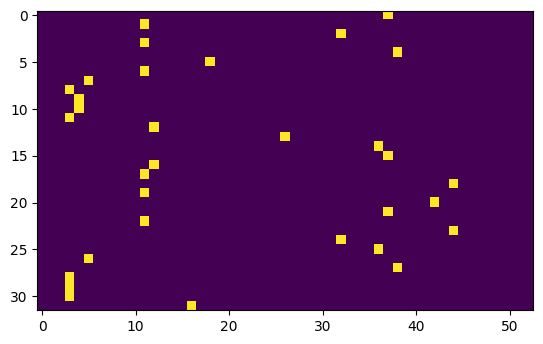

In [54]:
plt.imshow(F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]))

In [60]:
dlogits.shape, h.shape, W2.shape, b2.shape

(torch.Size([32, 53]),
 torch.Size([32, 64]),
 torch.Size([64, 53]),
 torch.Size([53]))

- Can derive a general method from a smaller matrix but can also use the shapes of the matrices as a guide to derive since the derivative is going to have the same shape

In [62]:
dh = dlogits @ W2.T 
dW2 = h.T @ dlogits
db2 = dlogits.sum(0)

In [71]:
hpreact.shape, bngain.shape, bnraw.shape, bnbias.shape

(torch.Size([32, 64]),
 torch.Size([1, 64]),
 torch.Size([32, 64]),
 torch.Size([1, 64]))

In [80]:
bnvar.shape, bnvar_inv.shape, bndiff2.shape

(torch.Size([1, 64]), torch.Size([1, 64]), torch.Size([32, 64]))

In [81]:
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0/n
dprobs = (1.0 / probs) * dlogprobs # chain rule d/dx of log(x) = 1/x  Essentially the lower the probability the greater the multiplication boost
dcounts_sum_inv = (counts * dprobs).sum(1, keepdims=True)
dcounts = counts_sum_inv * dprobs
dcounts_sum = (-counts_sum**-2) * dcounts_sum_inv
dcounts += dcounts_sum * torch.ones_like(counts)
dnorm_logits = counts * dcounts 
dlogits = dnorm_logits.clone() # partial
dlogit_maxes = (-dnorm_logits).sum(1, keepdim=True)
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes
dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(0)
dhpreact = (1.0 - h**2) * dh   # from tanh deriv formula 
dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
dbnraw = bngain * dhpreact
dbnbias = dhpreact.sum(0, keepdim=True)
dbndiff = bnvar_inv * dbnraw
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
dbndiff += (2*bndiff) * dbndiff2
# dhprebn = dbndiff.clone()
# dbnmeani = (-dbndiff).sum(0)
# dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)
# dembcat = dhprebn @ W1.T
# dW1 = embcat.T @ dhprebn
# db1 = dhprebn.sum(0)
# demb = dembcat.view(emb.shape)
# dC = torch.zeros_like(C)
# for k in range(Xb.shape[0]):
#   for j in range(Xb.shape[1]):
#     ix = Xb[k,j]
#     dC[ix] += demb[k,j]

In [82]:
cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
# cmp('bnmeani', dbnmeani, bnmeani)
# cmp('hprebn', dhprebn, hprebn)
# cmp('embcat', dembcat, embcat)
# cmp('W1', dW1, W1)
# cmp('b1', db1, b1)
# cmp('emb', demb, emb)
# cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: False | approximate: True  | maxdiff: 4.656612873077393e-10
bngain          | exact: False | approximate: True  | maxdiff: 1.862645149230957e-09
bnbias          | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09
bnraw   

#### Exercise 2: backprop through cross_entropy but all in one go to complete this challenge look at the mathematical expression of the loss, take the derivative, simplify the expression, and just write it out

#### forward pass

> before:
```python
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()
```

In [83]:
# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

4.134999752044678 diff: 0.0


#### Backprop
(Ans)

In [84]:
dlogits = F.softmax(logits, 1)
dlogits[range(n), Yb] -= 1
dlogits /= n

cmp('logits', dlogits, logits)

logits          | exact: False | approximate: True  | maxdiff: 6.51925802230835e-09


In [86]:
logits.shape, Yb.shape

(torch.Size([32, 53]), torch.Size([32]))

In [87]:
F.softmax(logits, 1)[0]

tensor([0.0222, 0.0313, 0.0137, 0.0209, 0.0246, 0.0309, 0.0208, 0.0170, 0.0189,
        0.0142, 0.0131, 0.0115, 0.0186, 0.0144, 0.0115, 0.0313, 0.0123, 0.0163,
        0.0333, 0.0104, 0.0222, 0.0162, 0.0090, 0.0122, 0.0097, 0.0121, 0.0217,
        0.0159, 0.0286, 0.0285, 0.0086, 0.0115, 0.0135, 0.0164, 0.0199, 0.0151,
        0.0305, 0.0447, 0.0225, 0.0286, 0.0281, 0.0162, 0.0068, 0.0220, 0.0329,
        0.0137, 0.0128, 0.0181, 0.0102, 0.0221, 0.0095, 0.0137, 0.0192],
       grad_fn=<SelectBackward0>)

In [88]:
dlogits[0] * n

tensor([ 0.0222,  0.0313,  0.0137,  0.0209,  0.0246,  0.0309,  0.0208,  0.0170,
         0.0189,  0.0142,  0.0131,  0.0115,  0.0186,  0.0144,  0.0115,  0.0313,
         0.0123,  0.0163,  0.0333,  0.0104,  0.0222,  0.0162,  0.0090,  0.0122,
         0.0097,  0.0121,  0.0217,  0.0159,  0.0286,  0.0285,  0.0086, -0.9885,
         0.0135,  0.0164,  0.0199,  0.0151,  0.0305,  0.0447,  0.0225,  0.0286,
         0.0281,  0.0162,  0.0068,  0.0220,  0.0329,  0.0137,  0.0128,  0.0181,
         0.0102,  0.0221,  0.0095,  0.0137,  0.0192], grad_fn=<MulBackward0>)

In [89]:
dlogits[0].sum()

tensor(3.7253e-09, grad_fn=<SumBackward0>)

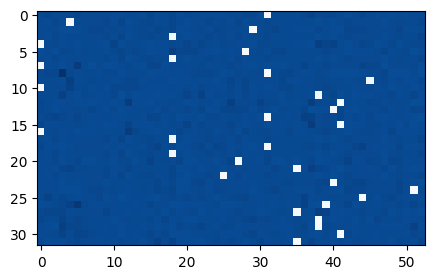

In [90]:
plt.figure(figsize=(5,5))
plt.imshow(dlogits.detach(), cmap='Blues')

#### Exercise 3: backprop through batchnorm but all in one go to complete this challenge look at the mathematical expression of the output of batchnorm, take the derivative w.r.t. its input, simplify the expression, and just write it out

#### forward pass

> before:
```python
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
```

In [91]:
# now:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


### backward pass

>before we had:
```python
dbnraw = bngain * dhpreact
dbndiff = bnvar_inv * dbnraw
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
dbndiff += (2*bndiff) * dbndiff2
dhprebn = dbndiff.clone()
dbnmeani = (-dbndiff).sum(0)
dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)
```
#### calculate dhprebn given dhpreact (i.e. backprop through the batchnorm)
(you'll also need to use some of the variables from the forward pass up above)

In [92]:
dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0) )

cmp('hprebn', dhprebn, hprebn)

hprebn          | exact: False | approximate: True  | maxdiff: 1.1641532182693481e-09


In [93]:
dhprebn.shape, bngain.shape, bnvar_inv.shape, dbnraw.shape, dbnraw.sum(0).shape

(torch.Size([32, 64]),
 torch.Size([1, 64]),
 torch.Size([1, 64]),
 torch.Size([32, 64]),
 torch.Size([64]))

### Exercise 4: putting it all together!
#### Train the MLP neural net with your own backward pass


In [12]:
# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
with torch.no_grad():

  # kick off optimization
  for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hprebn = embcat @ W1 + b1 # hidden layer pre-activation
    # BatchNorm layer
    # -------------------------------------------------------------
    bnmean = hprebn.mean(0, keepdim=True)
    bnvar = hprebn.var(0, keepdim=True, unbiased=True)
    bnvar_inv = (bnvar + 1e-5)**-0.5
    bnraw = (hprebn - bnmean) * bnvar_inv
    hpreact = bngain * bnraw + bnbias
    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
      p.grad = None
    #loss.backward() # use this for correctness comparisons, delete it later!

    # manual backprop!
    # -----------------
    dlogits = F.softmax(logits, 1)
    dlogits[range(n), Yb] -= 1
    dlogits /= n
    # 2nd layer backprop
    dh = dlogits @ W2.T
    dW2 = h.T @ dlogits
    db2 = dlogits.sum(0)
    # tanh
    dhpreact = (1.0 - h**2) * dh
    # batchnorm backprop
    dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
    dbnbias = dhpreact.sum(0, keepdim=True)
    dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
    # 1st layer
    dembcat = dhprebn @ W1.T
    dW1 = embcat.T @ dhprebn
    db1 = dhprebn.sum(0)
    # embedding
    demb = dembcat.view(emb.shape)
    dC = torch.zeros_like(C)
    for k in range(Xb.shape[0]):
      for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        dC[ix] += demb[k,j]
    grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
    # -----------------

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p, grad in zip(parameters, grads):
      #p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
      p.data += -lr * grad # new way of swole doge TODO: enable

    # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

17783
      0/ 200000: 4.4697
  10000/ 200000: 1.9537
  20000/ 200000: 1.7316
  30000/ 200000: 1.6490
  40000/ 200000: 1.7280
  50000/ 200000: 1.5921
  60000/ 200000: 2.0854
  70000/ 200000: 1.4935
  80000/ 200000: 1.8489
  90000/ 200000: 1.7028
 100000/ 200000: 1.8807
 110000/ 200000: 1.3902
 120000/ 200000: 1.3244
 130000/ 200000: 1.5188
 140000/ 200000: 2.1504
 150000/ 200000: 1.9290
 160000/ 200000: 1.8636
 170000/ 200000: 2.0175
 180000/ 200000: 1.4964
 190000/ 200000: 1.5058


In [ ]:
# useful for checking your gradients
# for p,g in zip(parameters, grads):
#     cmp(str(tuple(p.shape)), g, p)

In [14]:
# getting the bnmean and bnstd for the batch norm at the end of training

with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnvar = hpreact.var(0, keepdim=True, unbiased=True)

In [15]:
# evaluate train and val loss

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.6158115863800049
val 1.6194039583206177


In [16]:
split_loss('test')

test 1.6182787418365479


In [18]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # ------------
        # forward pass:
        # Embedding
        emb = C[torch.tensor([context])] # (1,block_size,d)      
        embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
        hpreact = embcat @ W1 + b1
        hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
        h = torch.tanh(hpreact) # (N, n_hidden)
        logits = h @ W2 + b2 # (N, vocab_size)
        # ------------
        # Sample
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

Meghaylonzarian.
Narolin.
Rayme.
Josu.
Lauriela.
Danie.
Jarvell.
Louianora.
Nina.
Penily.
Karib.
Shryn.
Greg.
Jayson.
Janie.
Jette.
Alex.
Beckeyshuana.
Fanna.
Kalyn.
